In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
train = pd.read_csv('train.csv',delimiter='~')
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,11755,After reading mixed reviews I almost didn't bo...,Google Chrome,Desktop,Good
1,33912,This motor inn is located about - city blocks ...,Firefox,Tablet,Good
2,10143,It was our first time there and surely not our...,Google Chrome,Mobile,Good
3,33114,"Great hotel in an excellent location, just off...",Mozilla,Desktop,Good
4,17464,We stayed at the hotel for - weeks to get away...,Google Chrome,Desktop,Good


In [3]:
train.Browser_Used.value_counts()

Firefox              5754
Edge                 5530
Google Chrome        3597
InternetExplorer     3538
Mozilla Firefox      3340
Mozilla              2397
IE                   1920
Chrome               1881
Internet Explorer    1635
Safari                306
Opera                 274
Name: Browser_Used, dtype: int64

In [4]:
Browser_Used_dummy = pd.get_dummies(train.Browser_Used, drop_first=True)
Browser_Used_dummy.head()

,Edge,Firefox,Google Chrome,IE,Internet Explorer,InternetExplorer,Mozilla,Mozilla Firefox,Opera,Safari
0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [5]:
train.Device_Used.value_counts()

Mobile     11639
Desktop    11630
Tablet      6903
Name: Device_Used, dtype: int64

In [6]:
Device_Used_dummy = pd.get_dummies(train.Device_Used, drop_first=True)
Device_Used_dummy.head()

,Mobile,Tablet
0,0,0
1,0,1
2,1,0
3,0,0
4,0,0


In [7]:
train.Is_Response.value_counts()

Good    20567
Bad      9605
Name: Is_Response, dtype: int64

In [8]:
Is_Response_dummy = pd.get_dummies(train.Is_Response, drop_first=True)
Is_Response_dummy.head()

,Good
0,1
1,1
2,1
3,1
4,1


# checking correalation of response with browser and device

In [9]:
Is_Response_dummy['Good'].corr(Device_Used_dummy['Mobile'])*100

4.197479897598591

In [10]:
Is_Response_dummy['Good'].corr(Device_Used_dummy['Tablet'])*100

-9.696811666903287

In [11]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Edge'])*100

-23.34675619068614

In [12]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Firefox'])*100

-19.002656093916634

In [13]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Google Chrome'])*100

14.558792299625974

__23% Edge__ and __19% Firefox__ users responding __Bad__

__15% Google chrome__ user responding __Good__

In [14]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['IE'])*100

9.799698458781473

In [15]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['InternetExplorer'])*100

14.02691737425386

In [16]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Internet Explorer'])*100

10.637771356804661

In [17]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Mozilla'])*100

-4.786588668252014

In [18]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Mozilla Firefox'])*100

4.3824159499932005

In [19]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Opera'])*100

-0.3580921603472698

In [20]:
Is_Response_dummy['Good'].corr(Browser_Used_dummy['Safari'])*100

1.023434533156754

In [21]:
train.isnull().values.any()

False

# Training data

In [22]:
train['text length'] = train['Description'].apply(len)
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,text length
0,11755,After reading mixed reviews I almost didn't bo...,Google Chrome,Desktop,Good,1230
1,33912,This motor inn is located about - city blocks ...,Firefox,Tablet,Good,615
2,10143,It was our first time there and surely not our...,Google Chrome,Mobile,Good,505
3,33114,"Great hotel in an excellent location, just off...",Mozilla,Desktop,Good,424
4,17464,We stayed at the hotel for - weeks to get away...,Google Chrome,Desktop,Good,654


# Exploratory data analysis

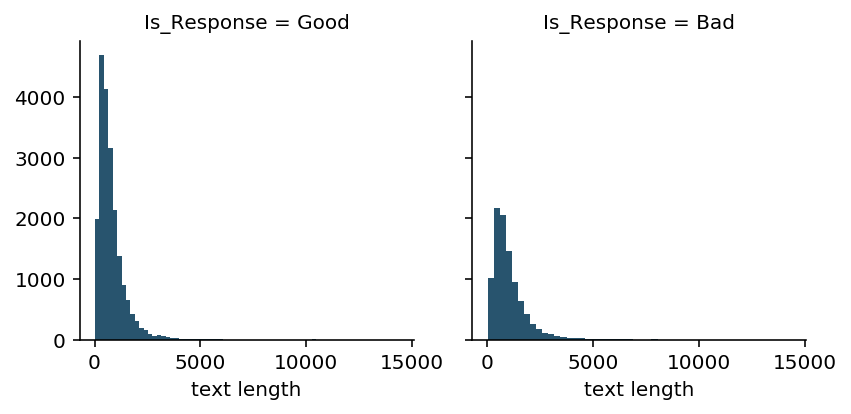

In [23]:
g = sns.FacetGrid(data=train , col='Is_Response')
g.map(plt.hist, 'text length', bins=50, color='#28546E')
plt.savefig('response_textlen', dpi=200)

Seems like overall, the distribution of text length is similar for both the responses. 

___However, the number of text reviews seems to be skewed a lot higher towards the good responses. This may cause some issues later on in the process.___

In [24]:
response =train.groupby('Is_Response').mean()
response

,User_ID,text length
Is_Response,,
Bad,19417.053306,1039.829256
Good,19384.177323,783.658531


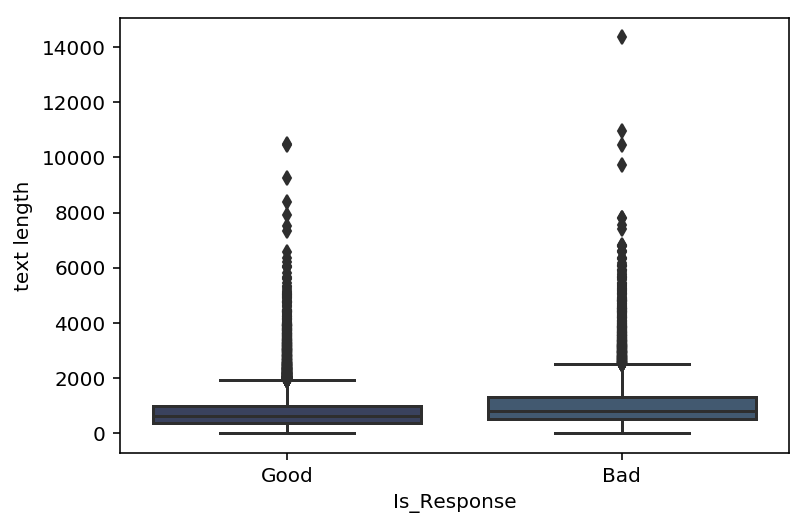

In [25]:
sns.boxplot(x='Is_Response', y='text length', data=train, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))
plt.savefig('response_textlen_box', dpi=200)

From the plot, looks like the __Bad__ response have much longer text, but there are many outliers (which can be seen as points above the boxes). 

___Because of this, maybe text length won’t be such a useful feature to consider after all.___

Let’s create a countplot of the number of occurrences for each type of response.

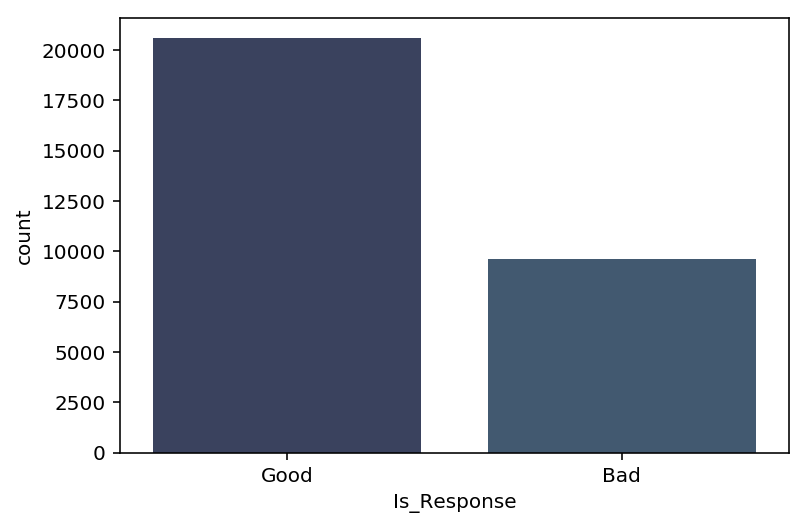

In [26]:
sns.countplot(x='Is_Response', data=train, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))

**Get the mean values of the numerical columns**


## NLP Classification Task

** Independent and dependent variables **

Next, let’s create the X and y for our classification task. X will be the text column of train, and y will be the response column.

Separate data into X and y

In [27]:
X = train['Description']
y = train['Is_Response']

### Text pre-processing
The main issue with our data is that it is all in plain-text format.

In [28]:
X[0]

"After reading mixed reviews I almost didn't book at the W, but I was attending a concert at the Pantages Theatre and you can't get any more convenient than the W. For those using mass transit, it's literally on top of the Hollywood and Vine station - take the Red Line from Union Station.\nATTITUDE: yes, this is a new and very hip hotel. But every staff member I met was friendly and totally committed to service. From the valet parking to the front desk to room service to the Men in Black (security folks needed for the club scene), everyone was great.\nFOOD: I always sample room service my first time at any property. Food arrived earlier than promised and I was impressed. The onion soup gratinee was simply the best I've ever had. A simple prime beef cheeseburger was great: a hand formed patty in a light bun with the usual trimmings and condiments. And the French fries... I've never been impressed by fries before but now I am.\nROOM: Trendy, well appointed and comfortable. The universal 

The classification algorithm will need some sort of feature vector in order to perform the classification task. 

The simplest way to convert a corpus to a vector format is the bag-of-words approach, where each unique word in a text will be represented by one number.

First, let’s write a function that will split a message into its individual words, and return a list.

We will also remove the very common words (such as “the”, “a”, “an”, etc.) and stopwords. 

To do this, we can take advantage of the NLTK library. The function below removes punctuation, stopwords, and returns a list of the remaining words, or tokens.

In [29]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# To check if the function works, let’s pass in some random text and 
# see if it gets processed correctly.
print(text_process("Hey there! This is a sample review, which happens to contain punctuations."))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


## Vectorisation

At the moment, we have our reviews as lists of tokens (also known as lemmas). To enable Scikit-learn algorithms to work on our text, we need to convert each review into a vector.

We can use Scikit-learn’s CountVectorizer to convert the text collection into a matrix of token counts. You can imagine this resulting matrix as a 2-D matrix, where each row is a unique word, and each column is a review.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

Since there are many reviews, we can expect a lot of zero counts for the presence of a word in the collection. Because of this, Scikit-learn will output a sparse matrix.

Let’s import CountVectorizer and fit an instance to our review text (stored in X), passing in our text_process function as the analyser.

Takes around 15 minutes

In [33]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

Now, we can look at the size of the vocabulary stored in the vectoriser (based on X) like this:

In [34]:
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

68894


To illustrate how the vectoriser works, let’s try a random review and get its bag-of-word counts as a vector. Here’s the twelveth review as plain-text:

In [35]:
response12 = X[11]
print(response12)

Do not stay here! The decor is okay, but I was not impressed with the service they have. Prices are reasonable but that is the kind of service you get. I normally stay at the Hotel Valencia but it was sold out. Stay if you want a low price but beware of what you are going to get.


Now let’s see our review represented as a vector:



In [36]:
bow12 = bow_transformer.transform([response12])
print(bow12)
print(bow12.shape)

  (0, 8621)	1
  (0, 14441)	1
  (0, 17433)	1
  (0, 19277)	1
  (0, 24856)	1
  (0, 31327)	1
  (0, 38290)	2
  (0, 38549)	1
  (0, 41669)	1
  (0, 43419)	1
  (0, 45046)	1
  (0, 48548)	1
  (0, 49144)	1
  (0, 52560)	1
  (0, 53926)	1
  (0, 57505)	2
  (0, 59270)	1
  (0, 60398)	2
  (0, 66557)	1
(1, 68894)


This means that there are 19 unique words in the review (after removing stopwords). Three of them appear twice, and the rest appear only once. Let’s go ahead and check which ones appear twice:

In [37]:
print(bow_transformer.get_feature_names()[38290])
print(bow_transformer.get_feature_names()[57505])
print(bow_transformer.get_feature_names()[60398])

get
service
stay


The vectorisation process working fine, we can transform our X dataframe into a sparse matrix. To do this, let’s use the .transform() method on our bag-of-words transformed object.

Takes around 18 minutes

In [38]:
X = bow_transformer.transform(X)

In [39]:
X

<30172x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 2027529 stored elements in Compressed Sparse Row format>

In [40]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (30172, 68894)
Amount of Non-Zero occurences:  2027529


In [41]:
# Number of non-zero messages against total number of messages
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('density: {}'.format((density)))

density: 0.09753973580665459


## Train Test Split

Test size: 30%

As we have finished processing the review text in X, It’s time to split our X and y into a training and a test set using train_test_split from Scikit-learn. We will use 30% of the dataset for testing.

In [42]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [103]:
X_train

<21120x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 1418147 stored elements in Compressed Sparse Row format>

In [104]:
X_test

<9052x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 609382 stored elements in Compressed Sparse Row format>

In [82]:
y_train.count()

21120

In [84]:
y_test.count()

9052

## Build and train model

#### Multinomial Naive Bayes model

A specialised version of Naive Bayes designed more for text documents. Let’s build a Multinomial Naive Bayes model and fit it to our training set (X_train and y_train).

In [51]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
# SMOTE

In [52]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

#### Predictions

Our model has now been trained! It’s time to see how well it predicts the ratings of previously unseen reviews (reviews from the test set). First, let’s store the predictions as a separate dataframe called preds.

In [53]:
preds = nb.predict(X_test)

#### Confusion matrix

Next, let’s evaluate our predictions against the actual ratings (stored in y_test) using confusion_matrix and classification_report from Scikit-learn.

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

In [55]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[2077  807]
 [ 403 5765]]


              precision    recall  f1-score   support

         Bad       0.84      0.72      0.77      2884
        Good       0.88      0.93      0.91      6168

   micro avg       0.87      0.87      0.87      9052
   macro avg       0.86      0.83      0.84      9052
weighted avg       0.86      0.87      0.86      9052



Looks like our model has achieved 87% accuracy! This means that our model can predict whether a user liked a local business or not, based on what they typed!

### Predicting a random positive review

Although our model achieved quite a high accuracy, ___there are some issues with bias caused by the dataset.___

Let’s take some singular reviews, and see what rating our model predicts for each one.

In [56]:
positive_review = train['Description'][53]
positive_review

"My wife and I were attending a reunion of her hospital unit from the Vietnam War era; attended by more than -- people.We had a river view room with a queen bed. The view from our room was worth the price of the room. From the moment we checked in, we were impressed with the outstanding front desk and housekeeping staff. The concierge went above and beyond providing outstanding service. When he found that we had made dinner arrangements at Keefer's, an excellent steak house, at the end of our meal, our server informed us that our dessert was courtesy of the hotel concierge.\nI am a disabled veteran with special dietary needs that the restaurant cheerfully accomodated.\nGreat food at a reasonable price. Overall, our experience in Chicago was equal to that of the top hotels of Bangkok, Shanghai, Kathmandu, or New Delhi."

We can expect our model to predict a rating of 5 for this review.

In [57]:
positive_review_transformed = bow_transformer.transform([positive_review])
positive_review_transformed

<1x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 68 stored elements in Compressed Sparse Row format>

In [58]:
nb.predict(positive_review_transformed)[0]

'Good'

Our model thinks this review is Good, just as we expected.

---

### Predicting a random negative review

In [59]:
negative_review = train['Description'][59]
negative_review

"Had made my reservation over a month and a half in advance. I had a confirmation number being held with my credit card. Padre game and some Jazz festival was in town so the hotel decided to over book the hotel. After the front desk girl disappeared for -- minutes and came back with a voucher to some hotel I'd never heard of on Coronado Island......we asked for a manager. He basically spent all of one minute saying too bad, your stay elsewhere is taken care of. They then gave us vouchers for cab rides that no cabbie would take to get to and from the game. (the reason we booked this hotel) The hotel they put us at had cockroaches at it and smelled worse than my grandma's attic on a hot summer day. The shower hardly worked. \nWant this to happen to you? DO NOT BOOK AT SAN DIEGO MARRIOTT GASLAMP QUARTER. The Hilton across the street looked really nice. Try them.\nIf the manager of this Marriott is reading this, you should be very ashamed of yourself and your staff. I know I am not the onl

In [60]:
negative_review_transformed = bow_transformer.transform([negative_review])
negative_review_transformed

<1x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [61]:
nb.predict(negative_review_transformed)[0]

'Bad'

Our model is right again!

---

### Predicting another random negative review

In [62]:
another_negative_review = train['Description'][16]
another_negative_review

'The service was great.But The rooms were nothing too special.Th breakfast has easy make waffles which are okay. It is a great place to stay if you are just heading down the highway looking for a place to stay!It is very convieniet to the highway. But from what i remember it was not at the airport exit.Overall I am not sure about staying here, if I found a better deal on a better more trusted brand hotel, with nicer rooms I would take the other hotel!\nHappy Travels!,\n Travel Al'

In [63]:
another_negative_review_transformed = bow_transformer.transform([another_negative_review])
another_negative_review_transformed

<1x68894 sparse matrix of type '<class 'numpy.int64'>'
	with 36 stored elements in Compressed Sparse Row format>

In [64]:
nb.predict(another_negative_review_transformed)[0]

'Good'

Our model thinks this review is Good, and that’s incorrect.

## Considering data bias

One explanation as to why this may be the case is that our initial dataset had a much higher number of Good reviews than Bad reviews. This means that the model is more biased towards Good reviews compared to Bad ones.

In conclusion, although our model was a little biased towards Good reviews, it was fairly accurate with its predictions, achieving an accuracy of 87% on the test set.

# Pedicting on test dataframe

In [66]:
test = pd.read_csv('test.csv',delimiter='~')
test.head()

,User_ID,Description,Browser_Used,Device_Used
0,9602,A friend and I stayed in this hotel when we we...,Edge,Desktop
1,8749,I enjoy staying here when I have early flights...,Google Chrome,Mobile
2,15500,I stopped off in Seattle during a train tour o...,Chrome,Mobile
3,5495,I have stayed at this hotel - or - times now f...,Mozilla Firefox,Desktop
4,18570,Excellent location with hop on hop off city tr...,Edge,Mobile


In [67]:
X_test = test['Description']
X_test_transformed = bow_transformer.transform(X_test)

In [69]:
prediction = nb.predict(X_test_transformed)
df = pd.DataFrame(prediction, columns = ['Is_Response'])
df.head()

,Is_Response
0,Bad
1,Good
2,Good
3,Good
4,Good


In [70]:
result = pd.concat([test, df], axis=1)
final_submission = result.loc[:,['User_ID','Is_Response']]
final_submission.head()

,User_ID,Is_Response
0,9602,Bad
1,8749,Good
2,15500,Good
3,5495,Good
4,18570,Good


In [71]:
final_submission.to_csv('final_sumbit.csv', index=False)

# BUILDING RANDOM FOREST MODEL

In [90]:
new_train=train
new_train['Is_Response'] = np.where(new_train['Is_Response']=='Good',1,0)
new_train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,text length
0,11755,After reading mixed reviews I almost didn't bo...,Google Chrome,Desktop,1,1230
1,33912,This motor inn is located about - city blocks ...,Firefox,Tablet,1,615
2,10143,It was our first time there and surely not our...,Google Chrome,Mobile,1,505
3,33114,"Great hotel in an excellent location, just off...",Mozilla,Desktop,1,424
4,17464,We stayed at the hotel for - weeks to get away...,Google Chrome,Desktop,1,654


In [91]:
new_y = new_train['Is_Response']

In [92]:
train_X, test_X, train_y, test_y = train_test_split(new_X, new_y, test_size=0.3, random_state=101)

In [78]:
from sklearn import metrics

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
RandomForestClassifier?

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [129]:
RandomForestRegressor?

In [96]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100 )
radm_clf.fit( X_train, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [106]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( X_test ) } )

In [1]:
radm_test_pred.head()

NameError: name 'radm_test_pred' is not defined

In [108]:
metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.824569155987627

Text(0.5,15,'Predicted label')

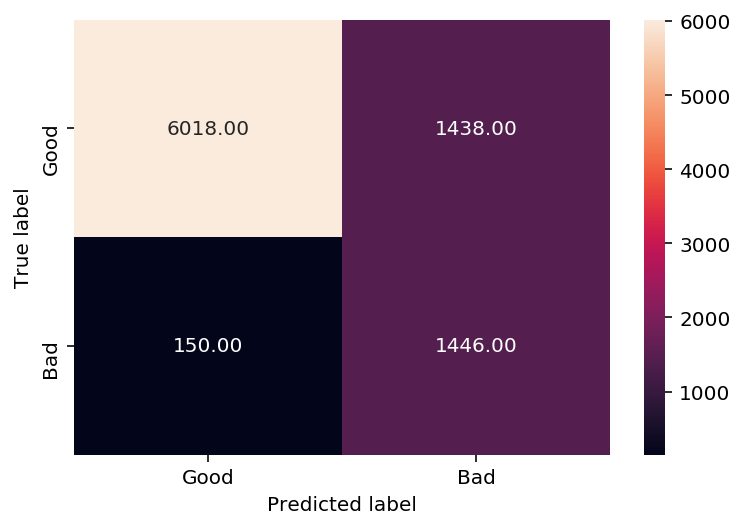

In [111]:
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Good", "Bad"] , yticklabels = ["Good", "Bad"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Feature importance from the Random Forest Model

In [112]:
radm_clf.feature_importances_

array([9.04461808e-06, 6.51021121e-05, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [113]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]

In [118]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(X_train.shape[1]):
    feature_rank.loc[f] = [f+1,
                         X_train.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

AttributeError: columns not found

<b> Note: </b>
As per the model, the most important features which influence whether to leave the company,in descending order, are

- satisfaction_level
- number_project
- time_spend_company
- last_evaluation
- average_montly_hours
- work_accident

### Boosting

#### Ada Boosting

In [119]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [120]:
pargrid_ada = {'n_estimators': [100, 200, 400, 600, 800],
               'learning_rate': [10 ** x for x in range(-3, 3)]}

In [121]:
from sklearn.grid_search import GridSearchCV
gscv_ada = GridSearchCV(estimator=AdaBoostClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [131]:
gscv_ada.fit(train_X, train_y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 400, 600, 800], 'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [132]:
gscv_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 800}

In [133]:
clf_ada = gscv_ada.best_estimator_

In [134]:
gscv_ada.best_score_

0.9615201447756929

In [135]:
ad=AdaBoostClassifier(learning_rate = 0.1, n_estimators=800)
ad.fit(train_X, train_y )

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=800, random_state=None)

In [136]:
from sklearn.cross_validation import cross_val_score

In [139]:
print(pd.Series(cross_val_score(clf_ada, train_X, train_y, cv=10)).describe()[['min', 'mean', 'max']])

print(pd.Series(cross_val_score(clf_ada, test_X, test_y, cv=10)).describe()[['min', 'mean', 'max']])

min     0.954286
mean    0.961901
max     0.971429
dtype: float64
min     0.946667
mean    0.959776
max     0.975556
dtype: float64


In [140]:
Series(cross_val_score(clf_ada, X_te, y_te, cv=10))

NameError: name 'Series' is not defined